In [1]:
try:
  import google.colab
  print("Running in a colab, all good")
except:
  raise "You need to run this notebook in a Google Colab !"

Running in a colab, all good


## Note before running the repo
In order to run this notebook, you need the datasets of cyclones, in a hierarchy as follows : 
```
data
  |--- ibtracs-gulf of mexico-1998-2015.csv
  |--- ibtracs-japan-1998-2015.csv
```
You can either upload the files manually to collab, or run the commands below to automatically download the files from our github repo

In [2]:
!mkdir data
!wget 'https://raw.githubusercontent.com/GGomez99/ds2-2023-Project2/main/project/arens-gomez-humeau-khieu/data/ibtracs-gulf%20of%20mexico-1998-2015.csv' -O "data/ibtracs-gulf of mexico-1998-2015.csv"
!wget 'https://raw.githubusercontent.com/GGomez99/ds2-2023-Project2/main/project/arens-gomez-humeau-khieu/data/ibtracs-japan-1998-2015.csv' -O "data/ibtracs-japan-1998-2015.csv"

mkdir: cannot create directory ‘data’: File exists
--2023-01-19 21:39:12--  https://raw.githubusercontent.com/GGomez99/ds2-2023-Project2/main/project/arens-gomez-humeau-khieu/data/ibtracs-gulf%20of%20mexico-1998-2015.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235033 (230K) [text/plain]
Saving to: ‘data/ibtracs-gulf of mexico-1998-2015.csv’

data/ibtracs-gulf o 100%[===================>] 229.52K  --.-KB/s    in 0.03s   

2023-01-19 21:39:12 (8.81 MB/s) - ‘data/ibtracs-gulf of mexico-1998-2015.csv’ saved [235033/235033]

--2023-01-19 21:39:12--  https://raw.githubusercontent.com/GGomez99/ds2-2023-Project2/main/project/arens-gomez-humeau-khieu/data/ibtracs-japan-1998-2015.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.10

## Parameters and variables

In [3]:
#Notebook parameters
#zoneAnalysis = "Japan"
zoneAnalysis = "Gulf of Mexico"

In [4]:
#usefull global variables
maxLon, minLon, maxLat, minLat = 0,0,0,0
minYear = 1998
maxYear = 2015

if (zoneAnalysis == "Gulf of Mexico"):
    maxLon = 282
    minLon = 256
    maxLat = 32
    minLat = 18
else:
    maxLon = 145
    minLon = 120
    maxLat = 40
    minLat = 20

## Initialisation & Data loading

In [5]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached basemap-1.3.6-cp38-cp38-manylinux1_x86_64.whl (863 kB)
  Using cached basemap_data-1.3.2-py2.py3-none-any.whl (30.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 46.6 MB/s eta 0:00:00
  Using cached pyproj-3.4.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.


In [6]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
import numpy as np
from scipy.stats.mstats import zscore
import warnings, gc
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(15,15) # graph size

Populating the interactive namespace from numpy and matplotlib


In [7]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='robin',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    
# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

**Connection to the GCP:**

First, we have to connect to the Google Cloud Platform. Enter the login "bigdataocean2020@gmail.com" and password "bdoimt2023". Do it only once. We will maybe need an authentication: contact me at pierre.tandeo@imt-atlantique.fr.

In [8]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

In [9]:
params = {"min_lat": minLat, "max_lat": maxLat, "min_lon": minLon, "max_lon": maxLon}

### SST & SSH request to bigquery database

In [10]:
%%bigquery output --project alert-ground-261008 --params $params
SELECT ROUND(lon) as lon, ROUND(lat) as lat, year, month, day, AVG(sst) AS sst, AVG(ssh) AS ssh
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>@min_lon AND lon<@max_lon AND lat>@min_lat AND lat<@max_lat
GROUP BY ROUND(lon), ROUND(lat), year, month, day

Query is running:   0%|          |

Downloading:   0%|          |

### IBTRACS data loading

In [11]:
#data loading from zone files
cyclonesData: pd.DataFrame
if (zoneAnalysis == "Japan"):
    cyclonesData = pd.read_csv("data/ibtracs-japan-1998-2015.csv")
else:
    cyclonesData = pd.read_csv("data/ibtracs-gulf of mexico-1998-2015.csv")

#time conversion
cyclonesData.ISO_TIME = pd.to_datetime(cyclonesData.ISO_TIME)
cyclonesData["NSEC_TIME"] = cyclonesData.NSEC_TIME.astype("int64")

## Data formating & merging for final dataset

In [12]:
output["ISO_TIME"] = pd.to_datetime(output[['year','month','day']])
output["NSEC_TIME"] = output.ISO_TIME.astype("int64")
output.rename(columns={"lon": "LON", "lat": "LAT"}, inplace=True)
output.head()

,LON,LAT,year,month,day,sst,ssh,ISO_TIME,NSEC_TIME
0,272.0,23.0,1998,1,2,23.953125,0.209775,1998-01-02,883699200000000000
1,272.0,22.0,1998,8,31,29.062500,0.263825,1998-08-31,904521600000000000
2,272.0,29.0,1999,1,31,21.730000,0.180493,1999-01-31,917740800000000000
3,272.0,24.0,1999,10,24,27.684375,0.301375,1999-10-24,940723200000000000
4,272.0,23.0,2000,3,3,24.618750,0.212488,2000-03-03,952041600000000000


In [13]:
coordDegreeMultiple = 0.250

cyclonesData.ISO_TIME = pd.to_datetime(cyclonesData.ISO_TIME.dt.date)
cyclonesData["CYCLONE_PRESENT"] = 1
cyclonesData[["LAT", "LON"]] = cyclonesData[["LAT", "LON"]].round()
"""cyclonesData[["LAT", "LON"]] = (cyclonesData[["LAT", "LON"]] - coordDegreeMultiple/2) / coordDegreeMultiple
cyclonesData[["LAT", "LON"]] = cyclonesData[["LAT", "LON"]].round()
cyclonesData[["LAT", "LON"]] = cyclonesData[["LAT", "LON"]] * coordDegreeMultiple + coordDegreeMultiple/2"""
cyclonesData.head()

,LAT,LON,SID,USA_WIND,CATEGORY,NSEC_TIME,ISO_TIME,CYCLONE_PRESENT
0,25.0,268.0,1998233N25268,25.0,TD,903679200000000000,1998-08-21,1
1,25.0,267.0,1998233N25268,27.0,TD,903690000000000000,1998-08-21,1
2,25.0,266.0,1998233N25268,30.0,TD,903700800000000000,1998-08-21,1
3,26.0,266.0,1998233N25268,35.0,TS,903711600000000000,1998-08-21,1
4,26.0,266.0,1998233N25268,40.0,TS,903722400000000000,1998-08-21,1


In [14]:
finalData = pd.merge(left=output, right=cyclonesData[['LON', 'LAT', "ISO_TIME", "CYCLONE_PRESENT", "SID"]], how="left", on=['LON', 'LAT','ISO_TIME'])
finalData.head()

,LON,LAT,year,month,day,sst,ssh,ISO_TIME,NSEC_TIME,CYCLONE_PRESENT,SID
0,272.0,23.0,1998,1,2,23.953125,0.209775,1998-01-02,883699200000000000,NaN,NaN
1,272.0,22.0,1998,8,31,29.062500,0.263825,1998-08-31,904521600000000000,NaN,NaN
2,272.0,29.0,1999,1,31,21.730000,0.180493,1999-01-31,917740800000000000,NaN,NaN
3,272.0,24.0,1999,10,24,27.684375,0.301375,1999-10-24,940723200000000000,NaN,NaN
4,272.0,23.0,2000,3,3,24.618750,0.212488,2000-03-03,952041600000000000,NaN,NaN


In [15]:
print("From all unique cyclones :",cyclonesData["SID"].nunique())
print(finalData["SID"].nunique(), "were matched in the sst/ssh dataset")

From all unique cyclones : 134
121 were matched in the sst/ssh dataset


Here, we found that not all cyclones in the selected area are matched with the uniform and complete data.
The following code shows why :

In [16]:
cyclonePoints = finalData[finalData["SID"].isna() == False][['LAT', 'LON', 'SID', 'ISO_TIME', "sst"]]
cyclonesWithSST = pd.merge(left=cyclonesData, right=cyclonePoints, how="left", on=['LAT', 'LON', 'SID', 'ISO_TIME'])
cyclonesWithSST.head()

,LAT,LON,SID,USA_WIND,CATEGORY,NSEC_TIME,ISO_TIME,CYCLONE_PRESENT,sst
0,25.0,268.0,1998233N25268,25.0,TD,903679200000000000,1998-08-21,1,30.496875
1,25.0,267.0,1998233N25268,27.0,TD,903690000000000000,1998-08-21,1,30.534375
2,25.0,266.0,1998233N25268,30.0,TD,903700800000000000,1998-08-21,1,30.496875
3,26.0,266.0,1998233N25268,35.0,TS,903711600000000000,1998-08-21,1,30.234375
4,26.0,266.0,1998233N25268,35.0,TS,903711600000000000,1998-08-21,1,30.234375


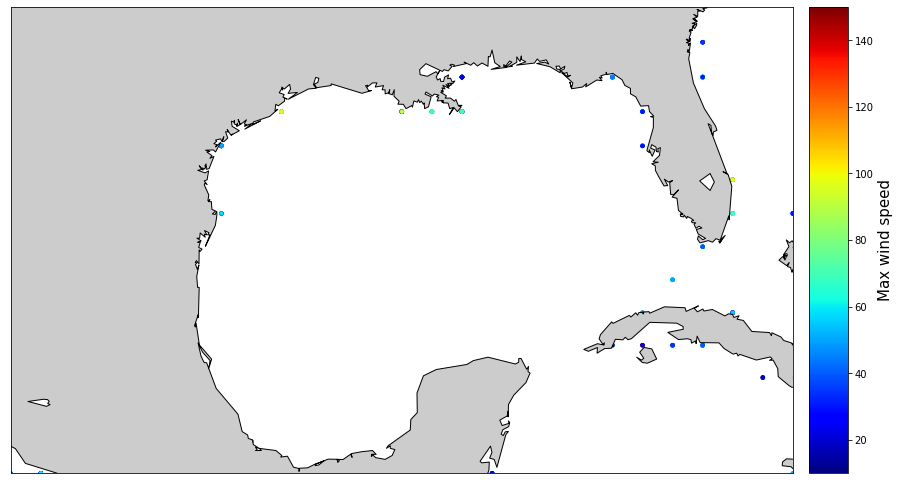

In [17]:
missingData = cyclonesWithSST[cyclonesWithSST["sst"].isna()]
plot_im(missingData.LON, missingData.LAT, missingData.USA_WIND, 20,  "Max wind speed")

As expected, we can't study the cyclone points that are too close to the coast, since we don't have sst data there.

Let's save a new dataset, with all the cyclones points close to the coast removed.

In [18]:
cyclonesWithSST.dropna().drop(columns=["CYCLONE_PRESENT", "sst"]).to_csv("data/ibtracs-"+zoneAnalysis.lower()+"-1998-2015-sst-adapted.csv")

In [19]:
#free memory
del cyclonePoints
del cyclonesData
del cyclonesWithSST
del missingData

In [20]:
gc.collect()

0

# Model cyclone apparition prediction


## Hyperparameters selection

In [21]:
#free up memory
del output
gc.collect()

4103

In [22]:
feature_names = ["LON", "LAT", "year", "month", "day", "sst", "ssh", "NSEC_TIME"]

In [23]:
finalData["CYCLONE_PRESENT"].fillna(0, inplace=True)
if "SID" in finalData.columns: finalData.drop(columns=["SID"], inplace=True)
finalData.head()

,LON,LAT,year,month,day,sst,ssh,ISO_TIME,NSEC_TIME,CYCLONE_PRESENT
0,272.0,23.0,1998,1,2,23.953125,0.209775,1998-01-02,883699200000000000,0.0
1,272.0,22.0,1998,8,31,29.062500,0.263825,1998-08-31,904521600000000000,0.0
2,272.0,29.0,1999,1,31,21.730000,0.180493,1999-01-31,917740800000000000,0.0
3,272.0,24.0,1999,10,24,27.684375,0.301375,1999-10-24,940723200000000000,0.0
4,272.0,23.0,2000,3,3,24.618750,0.212488,2000-03-03,952041600000000000,0.0


In [24]:
cyclonePtCount = len(finalData[finalData.CYCLONE_PRESENT == 1])
totalDataCount = len(finalData)

print("Points labelled as cyclone present : ", cyclonePtCount, f'({cyclonePtCount/totalDataCount*100:.{2}f}%)')
print("Points labelled as cyclone not present : ",  totalDataCount-cyclonePtCount, f'({(1-cyclonePtCount/totalDataCount)*100:.{2}f}%)')

Points labelled as cyclone present :  2043 (0.16%)
Points labelled as cyclone not present :  1254497 (99.84%)


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay

In [28]:
def generateData(positive_ratio, train_test_ratio):
    data = finalData[finalData["CYCLONE_PRESENT"] == 1] #getting all positive data
    data = pd.concat([
        data, 
        finalData.sample(int(len(data)*(1-positive_ratio)/positive_ratio))
    ]) #mixing with negative data
    data.sort_values("NSEC_TIME", inplace=True)

    x = data[feature_names]
    y = data["CYCLONE_PRESENT"]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=train_test_ratio, shuffle=False)

    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    return x_train, x_test, y_train, y_test, scaler

In [34]:
train_test_ratios = np.linspace(0.5, 0.9, 5)
positive_ratios = np.linspace(0.1, 0.7, 7)
precisionMatrix = []
recallMatrix = []
precisionValidMatrix = []
recallValidMatrix = []

for positive_ratio in positive_ratios:
    precisionSubMatrix = []
    recallSubMatrix = []
    precisionValidSubMatrix = []
    recallValidSubMatrix = []
    for train_test_ratio in train_test_ratios:
        print("Testing for pos/neg ratio :", positive_ratio, "; train/test :", train_test_ratio)
        #--------------data splitting
        x_train, x_test, y_train, y_test, scaler = generateData(positive_ratio, train_test_ratio)

        #-------------fitting
        model = RandomForestClassifier()

        model.fit(x_train, y_train)

        #-------------testing
        y_pred = model.predict(x_test)

        prec = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        precisionSubMatrix.append(prec)
        recallSubMatrix.append(recall)

        #--------------validation
        latest_train_date = scaler.inverse_transform(x_train[argmax(x_train[:, -1])].reshape(1,-1))[0][-1]
        validation_data = finalData[finalData["NSEC_TIME"] > latest_train_date]

        x_valid = validation_data[feature_names]
        y_valid = validation_data["CYCLONE_PRESENT"]

        y_pred_valid = model.predict(scaler.transform(x_valid))

        prec_valid = precision_score(y_valid, y_pred_valid)
        recall_valid = recall_score(y_valid, y_pred_valid)

        precisionValidSubMatrix.append(prec_valid)
        recallValidSubMatrix.append(recall_valid)


    precisionSubMatrix.reverse()
    recallSubMatrix.reverse()
    precisionMatrix.append(precisionSubMatrix)
    recallMatrix.append(recallSubMatrix)
    
    precisionValidSubMatrix.reverse()
    recallValidSubMatrix.reverse()
    precisionValidMatrix.append(precisionValidSubMatrix)
    recallValidMatrix.append(recallValidSubMatrix)

precisionMatrix.reverse()
recallMatrix.reverse()
precisionValidMatrix.reverse()
recallValidMatrix.reverse()

Testing for pos/neg ratio : 0.1 ; train/test : 0.5
Testing for pos/neg ratio : 0.1 ; train/test : 0.6
Testing for pos/neg ratio : 0.1 ; train/test : 0.7
Testing for pos/neg ratio : 0.1 ; train/test : 0.8
Testing for pos/neg ratio : 0.1 ; train/test : 0.9
Testing for pos/neg ratio : 0.2 ; train/test : 0.5
Testing for pos/neg ratio : 0.2 ; train/test : 0.6
Testing for pos/neg ratio : 0.2 ; train/test : 0.7
Testing for pos/neg ratio : 0.2 ; train/test : 0.8
Testing for pos/neg ratio : 0.2 ; train/test : 0.9
Testing for pos/neg ratio : 0.3 ; train/test : 0.5
Testing for pos/neg ratio : 0.3 ; train/test : 0.6
Testing for pos/neg ratio : 0.3 ; train/test : 0.7
Testing for pos/neg ratio : 0.3 ; train/test : 0.8
Testing for pos/neg ratio : 0.3 ; train/test : 0.9
Testing for pos/neg ratio : 0.4 ; train/test : 0.5
Testing for pos/neg ratio : 0.4 ; train/test : 0.6
Testing for pos/neg ratio : 0.4 ; train/test : 0.7
Testing for pos/neg ratio : 0.4 ; train/test : 0.8
Testing for pos/neg ratio : 0.4

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_score(ax, matrixScore, titleTxt):
    im = ax.imshow(matrixScore, cmap= 'viridis', vmin=0, vmax=1)

    ax.set_xticks([i for i in range(len(train_test_ratios))])
    ax.set_xticklabels(train_test_ratios)
    ax.set_xlabel("Train/Test ratio", size=20)

    ax.set_yticks([i for i in range(len(positive_ratios))])
    ax.set_yticklabels(np.flip(positive_ratios))
    ax.set_ylabel("Positive/Negative ratio", size=20)

    ax.set_title(titleTxt, size=20)
    return im

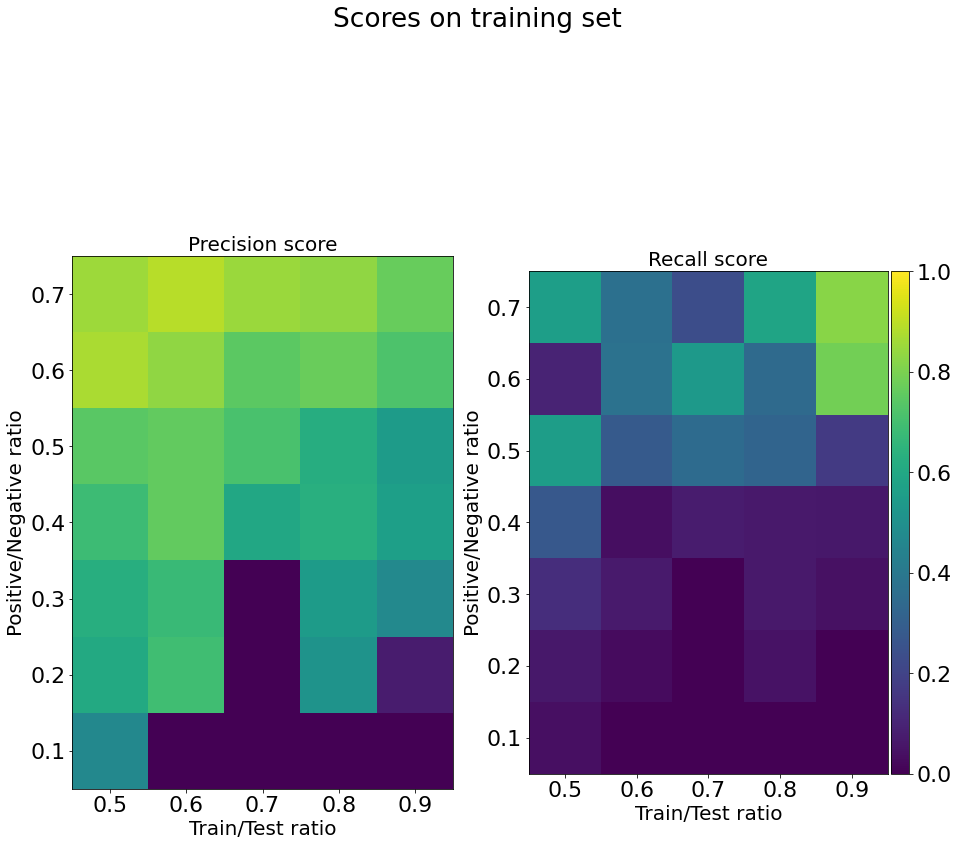

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Scores on training set')
im1 = plot_score(ax1, precisionMatrix, "Precision score")
im2 = plot_score(ax2, recallMatrix, "Recall score")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im1, cax=cax)

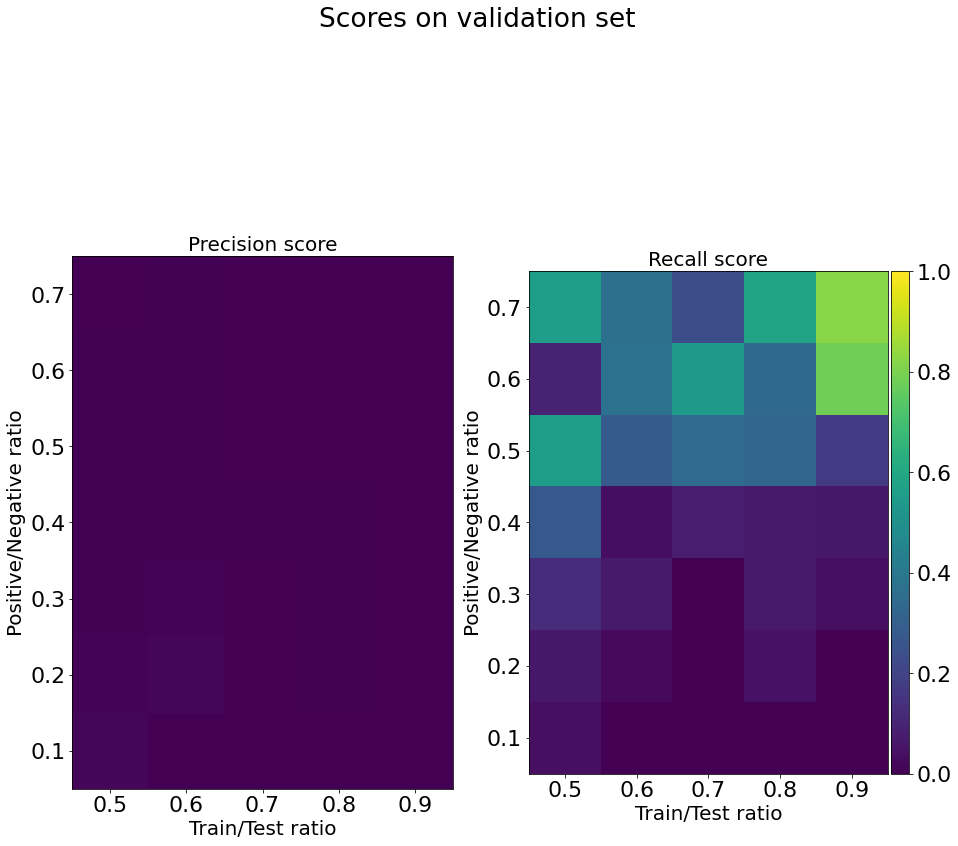

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Scores on validation set')
im1 = plot_score(ax1, precisionValidMatrix, "Precision score")
im2 = plot_score(ax2, recallValidMatrix, "Recall score")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im1, cax=cax)

In [38]:
maxForeach = [max(precisionValidMatrix[i]) for i in range(len(precisionValidMatrix))]
posRInd = maxForeach.index(max(maxForeach))
trainRInd = precisionValidMatrix[posRInd].index(max(precisionValidMatrix[posRInd]))
print("To maximize precision (",precisionValidMatrix[posRInd][trainRInd],"), best ratios are :")
print("Pos/Neg ratio :", np.flip(positive_ratios)[posRInd])
print("Train/Test ratio :", train_test_ratios[trainRInd])

To maximize precision ( 0.013448894202032277 ), best ratios are :
Pos/Neg ratio : 0.2
Train/Test ratio : 0.6


In [39]:
maxForeach = [max(recallValidMatrix[i]) for i in range(len(recallValidMatrix))]
posRInd = maxForeach.index(max(maxForeach))
trainRInd = recallValidMatrix[posRInd].index(max(recallValidMatrix[posRInd]))
print("To maximize recall (",recallValidMatrix[posRInd][trainRInd],"), best ratios are :")
print("Pos/Neg ratio :", np.flip(positive_ratios)[posRInd])
print("Train/Test ratio :", train_test_ratios[trainRInd])

To maximize recall ( 0.8210526315789474 ), best ratios are :
Pos/Neg ratio : 0.7
Train/Test ratio : 0.9


## Model validation

In [40]:
bestPosR = 0.7
bestTrainTestR = 0.9

#validating model
#--------------data splitting
x_train, x_test, y_train, y_test, scaler = generateData(bestPosR, bestTrainTestR)

#-------------fitting
model = RandomForestClassifier()

model.fit(x_train, y_train)

#-------------testing
y_pred = model.predict(x_test)

prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

#--------------validation
latest_train_date = scaler.inverse_transform(x_train[argmax(x_train[:, -1])].reshape(1,-1))[0][-1]
validation_data = finalData[finalData["NSEC_TIME"] > latest_train_date]

x_valid = validation_data[feature_names]
y_valid = validation_data["CYCLONE_PRESENT"]

y_pred_valid = model.predict(scaler.transform(x_valid))

prec_valid = precision_score(y_valid, y_pred_valid)
recall_valid = recall_score(y_valid, y_pred_valid)

print("Using pos/neg ratio =", bestPosR, "; train/test ratio =", bestTrainTestR)
print("Results for test set with", len(x_test), "points")
print("Precision :", prec)
print("Recall :", recall)
print("-----------------------------------------")
print("Results for validation set with", len(x_valid), "points")
print("Precision valid :", prec_valid)
print("Recall valid :", recall_valid)

Using pos/neg ratio = 0.7 ; train/test ratio = 0.9
Results for test set with 2627 points
Precision : 0.8615257048092869
Recall : 0.5693150684931507
-----------------------------------------
Results for validation set with 1132301 points
Precision valid : 0.0041464465870634055
Recall valid : 0.5696271929824561


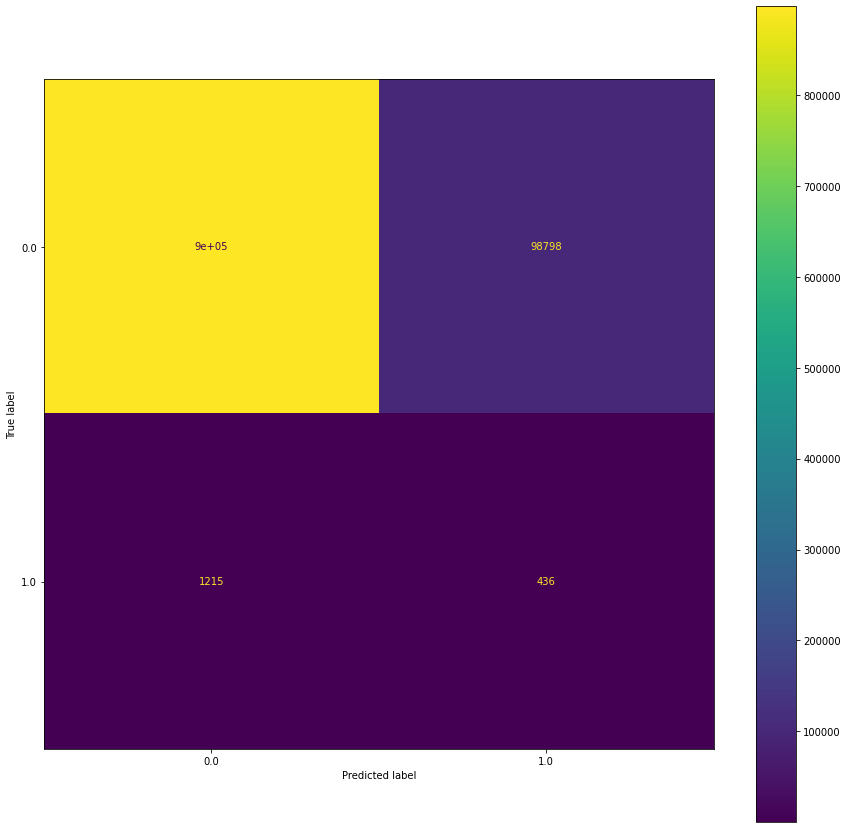

In [32]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_valid)

Text(0, 0.5, 'Mean decrease in impurity')

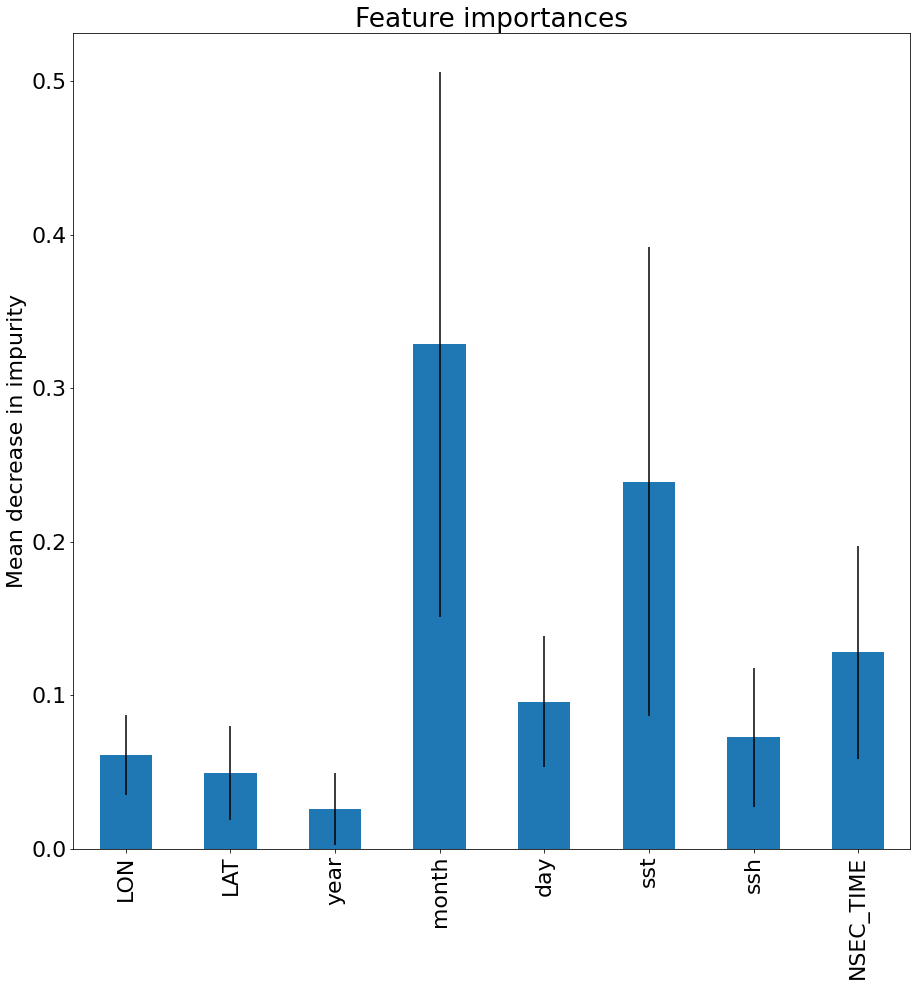

In [33]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")